In [ ]:
import pandas as pd
import numpy as np
import numpy.linalg
from scipy import stats
from scipy.stats import chi2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
# drive.mount('/content/drive')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import patsy

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan

# !pip install linearmodels
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare

In [ ]:
merged_df = pd.read_csv('/content/drive/My Drive/SIADS 699: Capstone/Clean Data/merged_data_complete.csv')

In [ ]:
# copy merged_df and prepare data for fixed effects panel regression on username

pr_username_df = merged_df.copy()

# cast columns to correct datatypes for analysis and clean up any remaining missing values
pr_username_df['prob_name'].fillna('Unknown', inplace=True)
pr_username_df['prob_grade_level'].fillna(0, inplace=True)
pr_username_df['probs_before_mastery'].fillna(0, inplace=True)
pr_username_df['practice'] = pr_username_df['practice'].astype(int)
pr_username_df['prob_timestamp'] = pd.to_datetime(pr_username_df['prob_timestamp'])
pr_username_df['prob_name'] = pr_username_df['prob_name'].astype('category')
pr_username_df['prob_grade_level'] = pr_username_df['prob_grade_level'].astype('category')

# set the MultiIndex to be username and prob_timestamp
pr_username_df.set_index(['username', 'prob_timestamp'], inplace=True)

# filter to only the features needed for regression
pr_username_df = pr_username_df[['probs_before_mastery', 'correct', 'practice', 'num_total', 'percent_correct', 'prob_name']]

<ipython-input-17-02a55458a773>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pr_username_df['prob_name'].fillna('Unknown', inplace=True)
<ipython-input-17-02a55458a773>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

In [ ]:
# run PooledOLS

pooled_formula = 'probs_before_mastery ~ correct + practice + num_total + percent_correct + C(prob_name) + EntityEffects'

pooled_model = PooledOLS.from_formula(pooled_formula, data=pr_username_df)
pooled_res = pooled_model.fit()
print(pooled_res.summary)

                           PooledOLS Estimation Summary                           
Dep. Variable:     probs_before_mastery   R-squared:                        0.1357
Estimator:                    PooledOLS   R-squared (Between):              0.3702
No. Observations:                 25542   R-squared (Within):               0.1165
Date:                  Fri, Apr 18 2025   R-squared (Overall):              0.1357
Time:                          01:41:12   Log-likelihood                -1.639e+05
Cov. Estimator:              Unadjusted                                           
                                          F-statistic:                      75.495
Entities:                             9   P-value                           0.0000
Avg Obs:                         2838.0   Distribution:                F(53,25488)
Min Obs:                         575.00                                           
Max Obs:                         7898.0   F-statistic (robust):             378.26
    

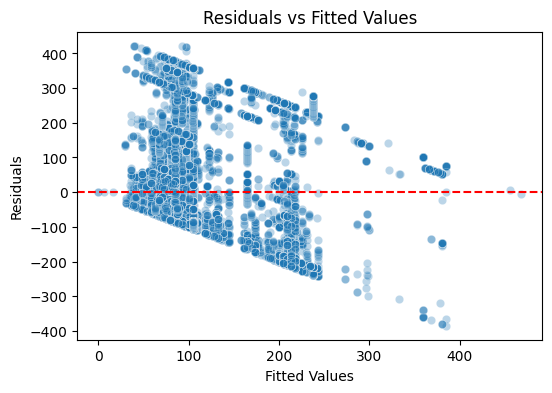

In [ ]:
# visual test for heteroskedasticity
residuals = pooled_res.resids.values.squeeze()
fitted = pooled_res.fitted_values.values.squeeze()

plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted, y=residuals, alpha=0.3)
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

In [ ]:
# Breusch-Pagan test for heterosckedasticity

residuals = np.array(pooled_res.resids.squeeze())
exog = pooled_res.model.exog.values2d
exog_with_const = add_constant(exog, has_constant='add')

bp_test = het_breuschpagan(residuals, exog_with_const)
bp_stat, bp_pvalue, f_stat, f_pvalue = bp_test

print("Breusch-Pagan Test Results")
print("---------------------------")
print(f"LM Statistic: {bp_stat:.4f}")
print(f"LM Test p-value: {bp_pvalue:.4f}")
print(f"F-statistic: {f_stat:.4f}")
print(f"F-test p-value: {f_pvalue:}")

Breusch-Pagan Test Results
---------------------------
LM Statistic: 3470.0659
LM Test p-value: 0.0000
F-statistic: 75.6062
F-test p-value: 0.0


In [ ]:
# strange spread of residuals and very low F-test p-value suggest heteroskedasticity
# Durbin-Watson test for autocorrelation
residuals = pooled_res.resids
dw_stat = sm.stats.stattools.durbin_watson(residuals)
print("Durbin-Watson Statistic:", dw_stat)

Durbin-Watson Statistic: 0.09383635547383276


In [ ]:
# Durbin-Watson stat is close to zero, suggesting strong auto-correlation
# we fail both tests and now should implement fixed/random effects panel regression

# fixed effects implementation

fe_formula = 'probs_before_mastery ~ correct + practice + num_total + percent_correct + C(prob_name) + EntityEffects'
fe_model = PanelOLS.from_formula(fe_formula, data=pr_username_df)
fe_res = fe_model.fit()
print(fe_res.summary)

                           PanelOLS Estimation Summary                            
Dep. Variable:     probs_before_mastery   R-squared:                        0.1187
Estimator:                     PanelOLS   R-squared (Between):              0.1147
No. Observations:                 25542   R-squared (Within):               0.1187
Date:                  Fri, Apr 18 2025   R-squared (Overall):              0.1331
Time:                          01:41:24   Log-likelihood                -1.637e+05
Cov. Estimator:              Unadjusted                                           
                                          F-statistic:                      64.746
Entities:                             9   P-value                           0.0000
Avg Obs:                         2838.0   Distribution:                F(53,25480)
Min Obs:                         575.00                                           
Max Obs:                         7898.0   F-statistic (robust):             372.69
    

In [ ]:
# random effects implementation
re_formula = 'probs_before_mastery ~ correct + practice + num_total + percent_correct + C(prob_name)'
re_model = RandomEffects.from_formula(re_formula, data=pr_username_df)
re_res = re_model.fit()
print(re_res.summary)

                         RandomEffects Estimation Summary                         
Dep. Variable:     probs_before_mastery   R-squared:                        0.1357
Estimator:                RandomEffects   R-squared (Between):              0.3702
No. Observations:                 25542   R-squared (Within):               0.1165
Date:                  Fri, Apr 18 2025   R-squared (Overall):              0.1357
Time:                          01:41:31   Log-likelihood                -1.639e+05
Cov. Estimator:              Unadjusted                                           
                                          F-statistic:                      75.495
Entities:                             9   P-value                           0.0000
Avg Obs:                         2838.0   Distribution:                F(53,25488)
Min Obs:                         575.00                                           
Max Obs:                         7898.0   F-statistic (robust):             378.26
    

In [ ]:
# results form fixed and random effects are similar, so try Hausman test to select best model

fe_coeffs = fe_res.params
re_coeffs = re_res.params

fe_cov = fe_res.cov
re_cov = re_res.cov

diff = fe_coeffs - re_coeffs
cov_diff = fe_cov - re_cov

H_stat = diff.T @ np.linalg.inv(cov_diff) @ diff
df = len(fe_coeffs)

p_value = 1 - chi2.cdf(H_stat, df)

# Output the Hausman test statistic and p-value
print("Hausman Test Statistic:", H_stat)
print("P-value:", p_value)

# Interpretation
if p_value < 0.05:
    print("Fixed Effects model is preferred (reject the null hypothesis).")
else:
    print("Random Effects model is preferred (fail to reject the null hypothesis).")

Hausman Test Statistic: 510.55015445934976
P-value: 0.0
Fixed Effects model is preferred (reject the null hypothesis).


In [ ]:
# the FE model is best so now we apply to test data and evaluate performance
# linearmodels does not have a .predict() method, so getting predictions proved more difficult than expected
# to maintain project scope and finish other ML tasks, we shifted intention of PR to be more focused on gaining insights than outputting predictions in 'real time'

pred_formula = 'correct + practice + num_total + percent_correct + C(prob_name)'
train_design_matrix = patsy.dmatrix(pred_formula, data=pr_username_df, return_type='dataframe')
test_design_matrix = patsy.dmatrix(pred_formula, data=pr_username_test_df, return_type='dataframe')

all_cols = list(set(train_design_matrix.columns) | set(test_design_matrix.columns))

for col in all_cols:
    if col not in train_design_matrix.columns:
        train_design_matrix[col] = 0
    if col not in test_design_matrix.columns:
        test_design_matrix[col] = 0

test_design_matrix = test_design_matrix[train_design_matrix.columns]

preds = fe_res.predict(data=test_design_matrix.values)
trues = pr_username_test_df['probs_before_mastery']

mse = mean_squared_error(trues, preds)
r2 = r2_score(trues, preds)
mae = mean_absolute_error(trues, preds)

print("MSE:", mse)
print("R^2:", r2)
print("MAE:", mae)

FactorEvaluationError: Unable to evaluate factor `practice`. [NameError: `practice` is not present in the dataset or evaluation context.]

In [ ]:
print(train_design_matrix.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 21868 entries, ('AyaA2', Timestamp('2024-10-09 09:31:36')) to ('PaytonP4', Timestamp('2024-08-29 13:27:25'))
Data columns (total 54 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Intercept             21868 non-null  float64
 1   C(prob_name)[T.AP5]   21868 non-null  float64
 2   C(prob_name)[T.AP8]   21868 non-null  float64
 3   C(prob_name)[T.AS1]   21868 non-null  float64
 4   C(prob_name)[T.AS2]   21868 non-null  float64
 5   C(prob_name)[T.AS3]   21868 non-null  float64
 6   C(prob_name)[T.AS6]   21868 non-null  float64
 7   C(prob_name)[T.COM1]  21868 non-null  float64
 8   C(prob_name)[T.COM2]  21868 non-null  float64
 9   C(prob_name)[T.COM3]  21868 non-null  float64
 10  C(prob_name)[T.COM4]  21868 non-null  float64
 11  C(prob_name)[T.COM5]  21868 non-null  float64
 12  C(prob_name)[T.COM6]  21868 non-null  float64
 13  C(prob_name)[T.DEC]   21868 non-null  

In [ ]:
print(test_design_matrix.columns)

Index(['Intercept', 'C(prob_name)[T.AP5]', 'C(prob_name)[T.AP8]',
       'C(prob_name)[T.AS1]', 'C(prob_name)[T.AS2]', 'C(prob_name)[T.AS3]',
       'C(prob_name)[T.AS6]', 'C(prob_name)[T.COM1]', 'C(prob_name)[T.COM2]',
       'C(prob_name)[T.COM3]', 'C(prob_name)[T.COM4]', 'C(prob_name)[T.COM5]',
       'C(prob_name)[T.COM6]', 'C(prob_name)[T.DEC]', 'C(prob_name)[T.DEC5]',
       'C(prob_name)[T.DEC6]', 'C(prob_name)[T.EXP6]', 'C(prob_name)[T.EXP7]',
       'C(prob_name)[T.EXP8]', 'C(prob_name)[T.FOR6]', 'C(prob_name)[T.FOR7]',
       'C(prob_name)[T.FR]', 'C(prob_name)[T.FR3]', 'C(prob_name)[T.FR5]',
       'C(prob_name)[T.FR6]', 'C(prob_name)[T.GMS6]', 'C(prob_name)[T.GMS7]',
       'C(prob_name)[T.GMS8]', 'C(prob_name)[T.LE6]', 'C(prob_name)[T.LE7]',
       'C(prob_name)[T.LE8]', 'C(prob_name)[T.LF7]', 'C(prob_name)[T.LF8]',
       'C(prob_name)[T.LG]', 'C(prob_name)[T.LG3]', 'C(prob_name)[T.LG5]',
       'C(prob_name)[T.LI6]', 'C(prob_name)[T.LI7]', 'C(prob_name)[T.MD]',
       'C

In [ ]:
# the FE model is best so now we apply to test data and evaluate performance

pred_formula = 'correct + practice + num_total + percent_correct + C(prob_name)'
test_design_matrix = patsy.dmatrix(pred_formula, data=pr_username_test_df, return_type='dataframe')
test_design_matrix = test_design_matrix.dropna()
pr_username_test_df = pr_username_test_df.loc[test_design_matrix.index]

coeffs = fe_res.params
coeffs = coeffs[coeffs.index != 'EntityEffects']
trues = pr_username_test_df['probs_before_mastery']
test_design_matrix = sm.add_constant(test_design_matrix)
preds = test_design_matrix.dot(coeffs)

mse = mean_squared_error(trues, preds)
r2 = r2_score(trues, preds)
mae = mean_absolute_error(trues, preds)

print("MSE:", mse)
print("R^2:", r2)
print("MAE:", mae)

ValueError: matrices are not aligned

In [ ]:
# visualize results for fixed effect panel regression